In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import talib
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
%matplotlib inline

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Use the most common symbols from your news analysis
stock_symbols = ['AAPL', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'NFLX']

# Define date range (last 2 years to match news data)
end_date = datetime.now()
start_date = end_date - timedelta(days=730)  # 2 years

print("Downloading stock data...")
stock_data = {}

for symbol in stock_symbols:
    try:
        # Download historical data
        stock_data[symbol] = yf.download(symbol, start=start_date, end=end_date)
        print(f" Downloaded {symbol}: {len(stock_data[symbol])} trading days")
    except Exception as e:
        print(f"✗ Failed to download {symbol}: {e}")

print(f"\nSuccessfully downloaded {len(stock_data)} stocks")

[*********************100%***********************]  1 of 1 completed


 Downloaded AAPL: 501 trading days


[*********************100%***********************]  1 of 1 completed


 Downloaded TSLA: 501 trading days


[*********************100%***********************]  1 of 1 completed


 Downloaded MSFT: 501 trading days


[*********************100%***********************]  1 of 1 completed


 Downloaded GOOGL: 501 trading days


[*********************100%***********************]  1 of 1 completed


 Downloaded AMZN: 501 trading days


[*********************100%***********************]  1 of 1 completed


 Downloaded META: 501 trading days


[*********************100%***********************]  1 of 1 completed


 Downloaded NVDA: 501 trading days


[*********************100%***********************]  1 of 1 completed

 Downloaded NFLX: 501 trading days

Successfully downloaded 8 stocks


In [3]:
#examining one stock to understand the data structure
symbol = 'AAPL'
if symbol in stock_data:
    df_stock = stock_data[symbol]
    print(f"=== {symbol} STOCK DATA ===")
    print(f"Shape: {df_stock.shape}")
    print(f"Date range: {df_stock.index.min()} to {df_stock.index.max()}")
    print("\nFirst 5 rows:")
    display(df_stock.head())
    
    print("\nData types:")
    print(df_stock.dtypes)
    
    print("\nBasic statistics:")
    display(df_stock.describe())

=== AAPL STOCK DATA ===
Shape: (501, 5)
Date range: 2023-11-24 00:00:00 to 2025-11-21 00:00:00

First 5 rows:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2023-11-24,188.192719,189.114011,187.479453,189.084292,24048300
2023-11-27,188.014389,188.886161,187.132716,188.143178,40552600
2023-11-28,188.618683,189.292329,187.628038,188.004488,38415400
2023-11-29,187.598328,190.292882,187.202076,189.114012,43014200
2023-11-30,188.172897,188.539446,186.429369,188.063926,48794400



Data types:
Price   Ticker
Close   AAPL      float64
High    AAPL      float64
Low     AAPL      float64
Open    AAPL      float64
Volume  AAPL        int64
dtype: object

Basic statistics:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,501.000000,501.000000,501.000000,501.000000,5.010000e+02
mean,214.408713,216.451145,212.158277,214.189157,5.609185e+07
std,26.365864,26.533677,26.078627,26.299909,2.700923e+07
min,163.664902,165.053568,162.752348,164.012069,2.323470e+07
25%,192.680344,194.116215,191.221231,192.611350,4.200560e+07
50%,216.240570,218.094218,213.299559,215.328145,4.899950e+07
75%,231.751846,233.153981,228.705636,231.308203,6.098990e+07
max,275.250000,277.051436,272.089996,276.721738,3.186799e+08


In [14]:
def calculate_technical_indicators_simple(df):
    """Calculate technical indicators with basic error handling"""
    df_tech = df.copy()
    
    # Get close prices as 1D array
    close_prices = np.array(df_tech['Close'], dtype=float)
    
    # Remove NaN values
    close_prices = close_prices[~np.isnan(close_prices)]
    
    if len(close_prices) < 20:
        print(f"Warning: Only {len(close_prices)} valid data points")
        # Set all to NaN if insufficient data
        df_tech['SMA_20'] = np.nan
        df_tech['SMA_50'] = np.nan
        df_tech['SMA_200'] = np.nan
        df_tech['EMA_12'] = np.nan
        df_tech['EMA_26'] = np.nan
        return df_tech
    
    try:
        # Calculate what we can based on available data
        if len(close_prices) >= 20:
            df_tech['SMA_20'] = talib.SMA(close_prices, timeperiod=20)
        if len(close_prices) >= 50:
            df_tech['SMA_50'] = talib.SMA(close_prices, timeperiod=50)
        if len(close_prices) >= 200:
            df_tech['SMA_200'] = talib.SMA(close_prices, timeperiod=200)
        else:
            df_tech['SMA_200'] = np.nan
            
        if len(close_prices) >= 12:
            df_tech['EMA_12'] = talib.EMA(close_prices, timeperiod=12)
        if len(close_prices) >= 26:
            df_tech['EMA_26'] = talib.EMA(close_prices, timeperiod=26)
            
        print(f"✓ Calculated indicators for {len(close_prices)} data points")
        
    except Exception as e:
        print(f"Error: {e}")
        # Fallback to pandas calculations
        df_tech['SMA_20'] = df_tech['Close'].rolling(window=20).mean()
        df_tech['SMA_50'] = df_tech['Close'].rolling(window=50).mean()
        df_tech['SMA_200'] = df_tech['Close'].rolling(window=200).mean()
        df_tech['EMA_12'] = df_tech['Close'].ewm(span=12).mean()
        df_tech['EMA_26'] = df_tech['Close'].ewm(span=26).mean()
        print("✓ Used pandas fallback for calculations")
    
    return df_tech

# Apply to all stocks - USE THE CORRECT FUNCTION NAME
for symbol, df in stock_data.items():
    stock_data[symbol] = calculate_technical_indicators_simple(df)  # Fixed function name

# Show results for one stock
symbol = 'AAPL'
display(stock_data[symbol][['Close', 'SMA_20', 'SMA_50', 'SMA_200']].tail(10))

✓ Calculated indicators for 501 data points
✓ Calculated indicators for 501 data points
✓ Calculated indicators for 501 data points
✓ Calculated indicators for 501 data points
✓ Calculated indicators for 501 data points
✓ Calculated indicators for 501 data points
✓ Calculated indicators for 501 data points
✓ Calculated indicators for 501 data points


Price,Close,SMA_20,SMA_50,SMA_200
Ticker,AAPL,,,
Date,,,,
2025-11-10,269.429993,263.202406,252.758199,224.133777
2025-11-11,275.250000,264.588404,253.673248,224.365901
2025-11-12,273.470001,265.806978,254.377867,224.547315
2025-11-13,272.950012,267.093961,255.045912,224.720654
2025-11-14,272.410004,268.112178,255.704954,224.900102
2025-11-17,267.459991,268.385876,256.301161,225.062715
2025-11-18,267.440002,268.632101,256.967501,225.264998
2025-11-19,268.559998,269.150116,257.807293,225.449039


In [16]:
def calculate_momentum_indicators_simple(df):
    """Calculate momentum indicators with basic error handling"""
    df_momentum = df.copy()
    
    # Get prices as 1D arrays
    close_prices = np.array(df_momentum['Close'], dtype=float)
    high_prices = np.array(df_momentum['High'], dtype=float)
    low_prices = np.array(df_momentum['Low'], dtype=float)
    
    # Remove NaN values
    close_prices = close_prices[~np.isnan(close_prices)]
    high_prices = high_prices[~np.isnan(high_prices)]
    low_prices = low_prices[~np.isnan(low_prices)]
    
    if len(close_prices) < 14:
        print(f"Warning: Only {len(close_prices)} valid data points for momentum indicators")
        # Set all to NaN if insufficient data
        df_momentum['RSI_14'] = np.nan
        df_momentum['MACD'] = np.nan
        df_momentum['MACD_Signal'] = np.nan
        df_momentum['MACD_Histogram'] = np.nan
        df_momentum['BB_Upper'] = np.nan
        df_momentum['BB_Middle'] = np.nan
        df_momentum['BB_Lower'] = np.nan
        df_momentum['Stoch_SlowK'] = np.nan
        df_momentum['Stoch_SlowD'] = np.nan
        return df_momentum
    
    try:
        # RSI (Relative Strength Index)
        if len(close_prices) >= 14:
            df_momentum['RSI_14'] = talib.RSI(close_prices, timeperiod=14)
        
        # MACD (Moving Average Convergence Divergence)
        if len(close_prices) >= 26:
            macd, macd_signal, macd_hist = talib.MACD(close_prices)
            df_momentum['MACD'] = macd
            df_momentum['MACD_Signal'] = macd_signal
            df_momentum['MACD_Histogram'] = macd_hist
        
        # Bollinger Bands
        if len(close_prices) >= 20:
            bb_upper, bb_middle, bb_lower = talib.BBANDS(close_prices)
            df_momentum['BB_Upper'] = bb_upper
            df_momentum['BB_Middle'] = bb_middle
            df_momentum['BB_Lower'] = bb_lower
        
        # Stochastic Oscillator
        if len(high_prices) >= 14 and len(low_prices) >= 14:
            slowk, slowd = talib.STOCH(high_prices, low_prices, close_prices)
            df_momentum['Stoch_SlowK'] = slowk
            df_momentum['Stoch_SlowD'] = slowd
            
        print(f"✓ Calculated momentum indicators for {len(close_prices)} data points")
        
    except Exception as e:
        print(f"Error in momentum indicators: {e}")
        # Set all to NaN if calculations fail
        df_momentum['RSI_14'] = np.nan
        df_momentum['MACD'] = np.nan
        df_momentum['MACD_Signal'] = np.nan
        df_momentum['MACD_Histogram'] = np.nan
        df_momentum['BB_Upper'] = np.nan
        df_momentum['BB_Middle'] = np.nan
        df_momentum['BB_Lower'] = np.nan
        df_momentum['Stoch_SlowK'] = np.nan
        df_momentum['Stoch_SlowD'] = np.nan
        print("✗ Momentum indicators calculation failed")
    
    return df_momentum

# Apply to all stocks
for symbol, df in stock_data.items():
    stock_data[symbol] = calculate_momentum_indicators_simple(df)

# Show momentum indicators for one stock
symbol = 'AAPL'
display(stock_data[symbol][['Close', 'RSI_14', 'MACD', 'MACD_Signal']].tail(10))

✓ Calculated momentum indicators for 501 data points
✓ Calculated momentum indicators for 501 data points
✓ Calculated momentum indicators for 501 data points
✓ Calculated momentum indicators for 501 data points
✓ Calculated momentum indicators for 501 data points
✓ Calculated momentum indicators for 501 data points
✓ Calculated momentum indicators for 501 data points
✓ Calculated momentum indicators for 501 data points


Price,Close,RSI_14,MACD,MACD_Signal
Ticker,AAPL,,,
Date,,,,
2025-11-10,269.429993,65.267807,5.344097,5.629021
2025-11-11,275.250000,71.676908,5.582243,5.619665
2025-11-12,273.470001,67.570136,5.563215,5.608375
2025-11-13,272.950012,66.373736,5.443428,5.575386
2025-11-14,272.410004,65.084912,5.244467,5.509202
2025-11-17,267.459991,54.615883,4.633946,5.334151
2025-11-18,267.440002,54.577705,4.101216,5.087564
2025-11-19,268.559998,56.416055,3.726441,4.815339


In [17]:
def calculate_volume_volatility_indicators_simple(df):
    """Calculate volume and volatility indicators with basic error handling"""
    df_vol = df.copy()
    
    # Get prices and volume as 1D arrays
    close_prices = np.array(df_vol['Close'], dtype=float)
    high_prices = np.array(df_vol['High'], dtype=float)
    low_prices = np.array(df_vol['Low'], dtype=float)
    volume_data = np.array(df_vol['Volume'], dtype=float)
    
    # Remove NaN values
    close_prices = close_prices[~np.isnan(close_prices)]
    high_prices = high_prices[~np.isnan(high_prices)]
    low_prices = low_prices[~np.isnan(low_prices)]
    volume_data = volume_data[~np.isnan(volume_data)]
    
    if len(close_prices) < 14:
        print(f"Warning: Only {len(close_prices)} valid data points for volume/volatility indicators")
        # Set all to NaN if insufficient data
        df_vol['ATR_14'] = np.nan
        df_vol['OBV'] = np.nan
        df_vol['ROC_10'] = np.nan
        df_vol['Daily_Return'] = np.nan
        return df_vol
    
    try:
        # Average True Range (ATR) - Volatility
        if len(high_prices) >= 14 and len(low_prices) >= 14:
            df_vol['ATR_14'] = talib.ATR(high_prices, low_prices, close_prices, timeperiod=14)
        
        # On Balance Volume (OBV)
        if len(close_prices) >= 1 and len(volume_data) >= 1:
            df_vol['OBV'] = talib.OBV(close_prices, volume_data)
        
        # Simple Rate of Change
        if len(close_prices) >= 10:
            df_vol['ROC_10'] = talib.ROC(close_prices, timeperiod=10)
        
        # Daily returns (using pandas since it's simple and reliable)
        df_vol['Daily_Return'] = df_vol['Close'].pct_change() * 100
            
        print(f"✓ Calculated volume/volatility indicators for {len(close_prices)} data points")
        
    except Exception as e:
        print(f"Error in volume/volatility indicators: {e}")
        # Set all to NaN if calculations fail
        df_vol['ATR_14'] = np.nan
        df_vol['OBV'] = np.nan
        df_vol['ROC_10'] = np.nan
        df_vol['Daily_Return'] = df_vol['Close'].pct_change() * 100  # Keep this one as it's pandas-based
        print("✗ Volume/volatility indicators calculation partially failed")
    
    return df_vol

# Apply to all stocks
for symbol, df in stock_data.items():
    stock_data[symbol] = calculate_volume_volatility_indicators_simple(df)

# Show results
symbol = 'AAPL'
display(stock_data[symbol][['Close', 'Volume', 'OBV', 'ATR_14', 'Daily_Return']].tail(10))

✓ Calculated volume/volatility indicators for 501 data points
✓ Calculated volume/volatility indicators for 501 data points
✓ Calculated volume/volatility indicators for 501 data points
✓ Calculated volume/volatility indicators for 501 data points
✓ Calculated volume/volatility indicators for 501 data points
✓ Calculated volume/volatility indicators for 501 data points
✓ Calculated volume/volatility indicators for 501 data points
✓ Calculated volume/volatility indicators for 501 data points


Price,Close,Volume,OBV,ATR_14,Daily_Return
Ticker,AAPL,AAPL,,,
Date,,,,,
2025-11-10,269.429993,41312400,1.697574e+09,5.205660,0.454868
2025-11-11,275.250000,46208300,1.743783e+09,5.296685,2.160119
2025-11-12,273.470001,48398000,1.695385e+09,5.206207,-0.646684
2025-11-13,272.950012,49602800,1.645782e+09,5.163622,-0.190145
2025-11-14,272.410004,47431300,1.598351e+09,5.249077,-0.197842
2025-11-17,267.459991,45018300,1.553332e+09,5.351285,-1.817118
2025-11-18,267.440002,45677300,1.507655e+09,5.354049,-0.007474
2025-11-19,268.559998,40424500,1.548080e+09,5.450902,0.418784


Plotting AAPL...


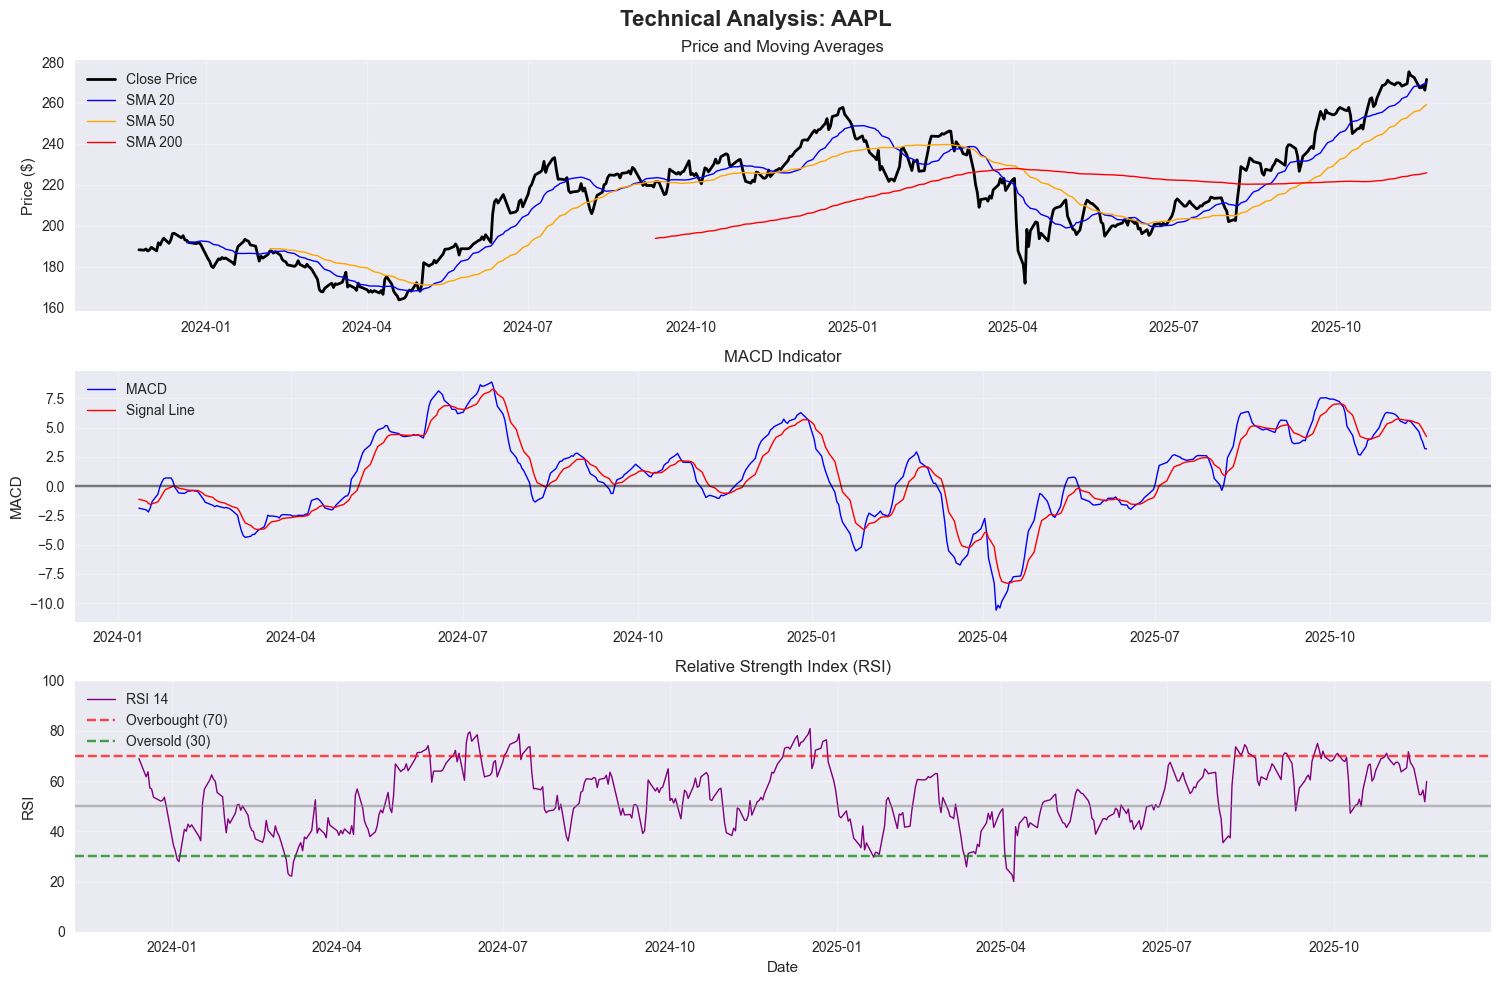

Plotting TSLA...


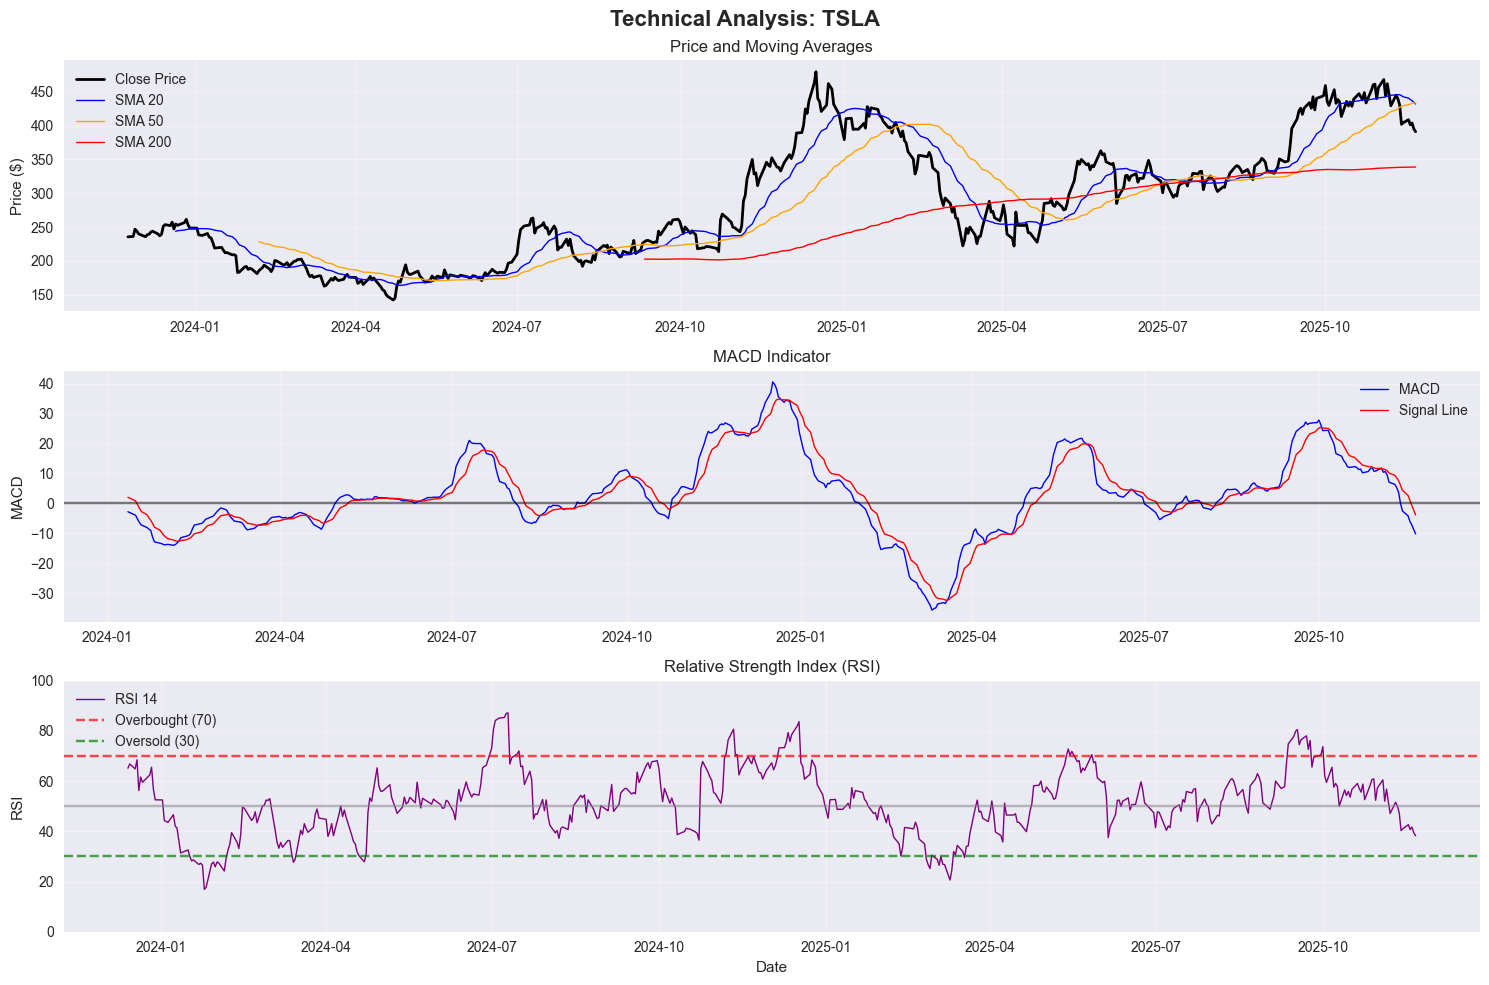

In [20]:
def plot_price_technical_analysis_simple(symbol, df):
    """Simplified technical analysis plot without volume bars"""
    try:
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        fig.suptitle(f'Technical Analysis: {symbol}', fontsize=16, fontweight='bold')
        
        # Plot 1: Price and Moving Averages
        axes[0].plot(df.index, df['Close'], label='Close Price', linewidth=2, color='black')
        
        if 'SMA_20' in df.columns and not df['SMA_20'].isna().all():
            axes[0].plot(df.index, df['SMA_20'], label='SMA 20', linewidth=1, color='blue')
        if 'SMA_50' in df.columns and not df['SMA_50'].isna().all():
            axes[0].plot(df.index, df['SMA_50'], label='SMA 50', linewidth=1, color='orange')
        if 'SMA_200' in df.columns and not df['SMA_200'].isna().all():
            axes[0].plot(df.index, df['SMA_200'], label='SMA 200', linewidth=1, color='red')
        
        axes[0].set_ylabel('Price ($)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        axes[0].set_title('Price and Moving Averages')
        
        # Plot 2: MACD
        if 'MACD' in df.columns and 'MACD_Signal' in df.columns:
            if not df['MACD'].isna().all() and not df['MACD_Signal'].isna().all():
                axes[1].plot(df.index, df['MACD'], label='MACD', linewidth=1, color='blue')
                axes[1].plot(df.index, df['MACD_Signal'], label='Signal Line', linewidth=1, color='red')
                axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
                axes[1].set_ylabel('MACD')
                axes[1].legend()
                axes[1].set_title('MACD Indicator')
            else:
                axes[1].text(0.5, 0.5, 'MACD data not available', ha='center', va='center', transform=axes[1].transAxes)
                axes[1].set_title('MACD Indicator (No Data)')
        else:
            axes[1].text(0.5, 0.5, 'MACD data not available', ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title('MACD Indicator (No Data)')
        axes[1].grid(True, alpha=0.3)
        
        # Plot 3: RSI
        if 'RSI_14' in df.columns and not df['RSI_14'].isna().all():
            axes[2].plot(df.index, df['RSI_14'], label='RSI 14', linewidth=1, color='purple')
            axes[2].axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
            axes[2].axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
            axes[2].axhline(y=50, color='gray', linestyle='-', alpha=0.5)
            axes[2].set_ylabel('RSI')
            axes[2].set_ylim(0, 100)
            axes[2].legend()
            axes[2].set_title('Relative Strength Index (RSI)')
        else:
            axes[2].text(0.5, 0.5, 'RSI data not available', ha='center', va='center', transform=axes[2].transAxes)
            axes[2].set_title('RSI (No Data)')
        axes[2].grid(True, alpha=0.3)
        axes[2].set_xlabel('Date')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating plot for {symbol}: {e}")
        plt.figure(figsize=(15, 10))
        plt.text(0.5, 0.5, f'Plot error for {symbol}', ha='center', va='center', fontsize=12)
        plt.title(f'Technical Analysis: {symbol} - Error')
        plt.show()

# the simple version
for symbol in ['AAPL', 'TSLA', 'MSFT'][:2]:
    if symbol in stock_data:
        print(f"Plotting {symbol}...")
        plot_price_technical_analysis_simple(symbol, stock_data[symbol])

Creating additional analysis for AAPL...


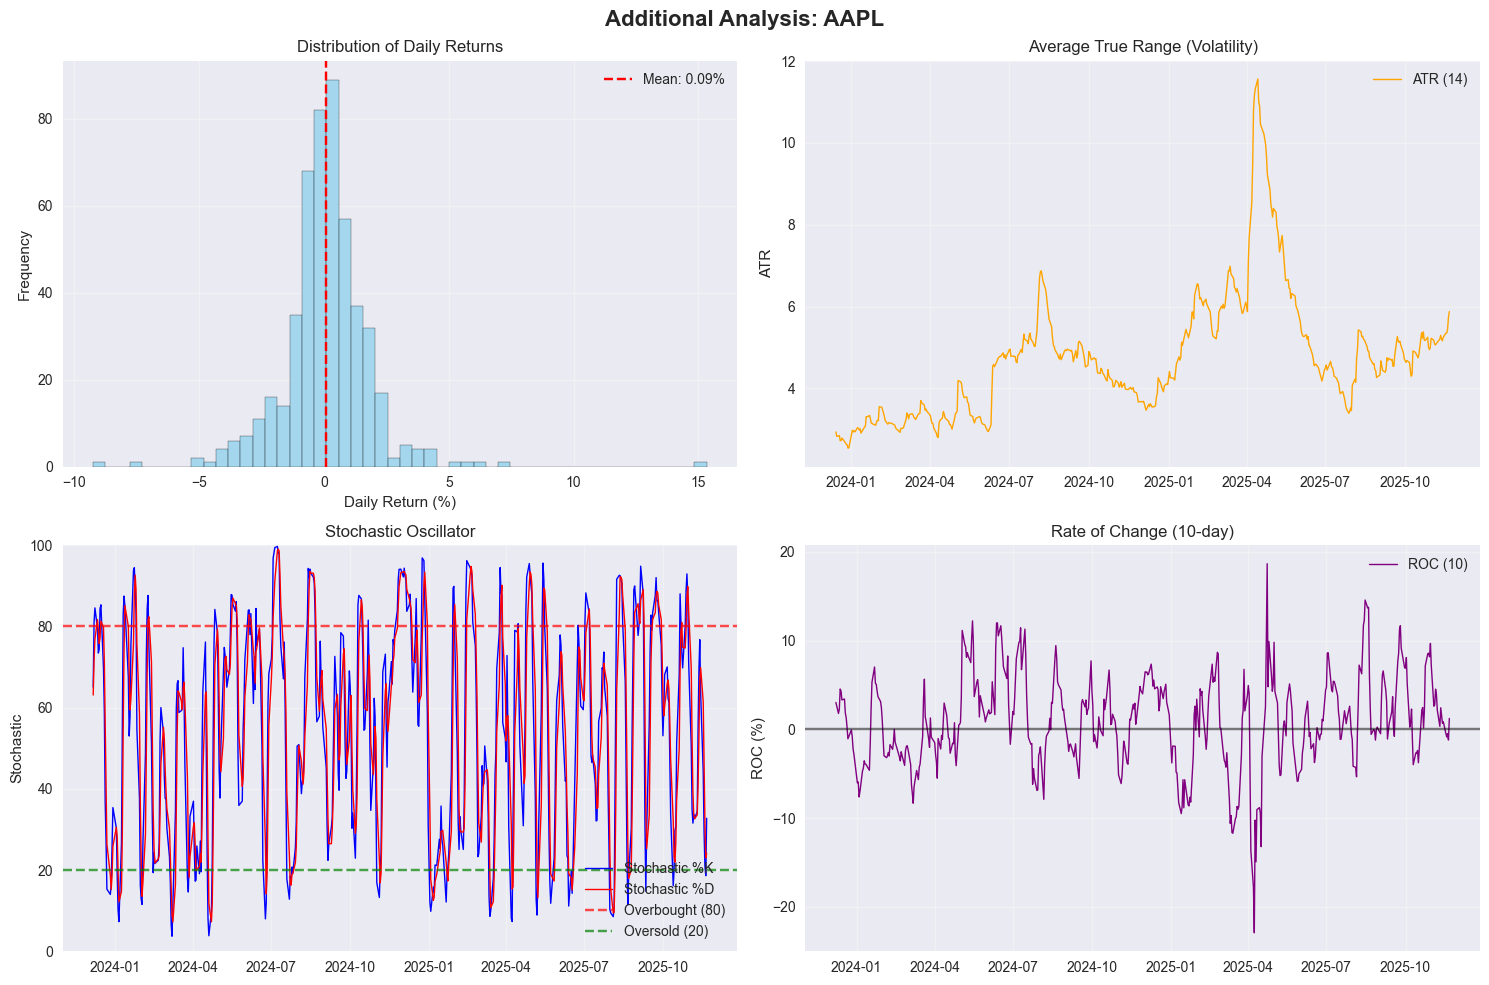

In [21]:
def plot_additional_analysis_simple(symbol, df):
    """Create additional analysis plots with robust error handling"""
    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Additional Analysis: {symbol}', fontsize=16, fontweight='bold')
        
        # Plot 1: Daily Returns Distribution
        if 'Daily_Return' in df.columns:
            daily_returns = df['Daily_Return'].dropna()
            if len(daily_returns) > 0:
                axes[0,0].hist(daily_returns, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
                axes[0,0].axvline(daily_returns.mean(), color='red', linestyle='--', label=f'Mean: {daily_returns.mean():.2f}%')
                axes[0,0].set_xlabel('Daily Return (%)')
                axes[0,0].set_ylabel('Frequency')
                axes[0,0].set_title('Distribution of Daily Returns')
                axes[0,0].legend()
            else:
                axes[0,0].text(0.5, 0.5, 'No daily return data', ha='center', va='center', transform=axes[0,0].transAxes)
                axes[0,0].set_title('Daily Returns (No Data)')
        else:
            axes[0,0].text(0.5, 0.5, 'Daily Return data not available', ha='center', va='center', transform=axes[0,0].transAxes)
            axes[0,0].set_title('Daily Returns (No Data)')
        axes[0,0].grid(True, alpha=0.3)
        
        # Plot 2: Volatility (ATR)
        if 'ATR_14' in df.columns and not df['ATR_14'].isna().all():
            axes[0,1].plot(df.index, df['ATR_14'], label='ATR (14)', linewidth=1, color='orange')
            axes[0,1].set_ylabel('ATR')
            axes[0,1].set_title('Average True Range (Volatility)')
            axes[0,1].legend()
        else:
            axes[0,1].text(0.5, 0.5, 'ATR data not available', ha='center', va='center', transform=axes[0,1].transAxes)
            axes[0,1].set_title('ATR (No Data)')
        axes[0,1].grid(True, alpha=0.3)
        
        # Plot 3: Stochastic Oscillator
        if 'Stoch_SlowK' in df.columns and 'Stoch_SlowD' in df.columns:
            if not df['Stoch_SlowK'].isna().all() and not df['Stoch_SlowD'].isna().all():
                axes[1,0].plot(df.index, df['Stoch_SlowK'], label='Stochastic %K', linewidth=1, color='blue')
                axes[1,0].plot(df.index, df['Stoch_SlowD'], label='Stochastic %D', linewidth=1, color='red')
                axes[1,0].axhline(y=80, color='red', linestyle='--', alpha=0.7, label='Overbought (80)')
                axes[1,0].axhline(y=20, color='green', linestyle='--', alpha=0.7, label='Oversold (20)')
                axes[1,0].set_ylabel('Stochastic')
                axes[1,0].set_ylim(0, 100)
                axes[1,0].set_title('Stochastic Oscillator')
                axes[1,0].legend()
            else:
                axes[1,0].text(0.5, 0.5, 'Stochastic data not available', ha='center', va='center', transform=axes[1,0].transAxes)
                axes[1,0].set_title('Stochastic (No Data)')
        else:
            axes[1,0].text(0.5, 0.5, 'Stochastic data not available', ha='center', va='center', transform=axes[1,0].transAxes)
            axes[1,0].set_title('Stochastic (No Data)')
        axes[1,0].grid(True, alpha=0.3)
        
        # Plot 4: Rate of Change
        if 'ROC_10' in df.columns and not df['ROC_10'].isna().all():
            axes[1,1].plot(df.index, df['ROC_10'], label='ROC (10)', linewidth=1, color='purple')
            axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
            axes[1,1].set_ylabel('ROC (%)')
            axes[1,1].set_title('Rate of Change (10-day)')
            axes[1,1].legend()
        else:
            axes[1,1].text(0.5, 0.5, 'ROC data not available', ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('ROC (No Data)')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating additional analysis plot for {symbol}: {e}")
        plt.figure(figsize=(15, 10))
        plt.text(0.5, 0.5, f'Additional analysis plot error for {symbol}', ha='center', va='center', fontsize=12)
        plt.title(f'Additional Analysis: {symbol} - Error')
        plt.show()

# Plot additional analysis
for symbol in ['AAPL', 'TSLA'][:1]:  # Just plot one to avoid too many plots
    if symbol in stock_data:
        print(f"Creating additional analysis for {symbol}...")
        plot_additional_analysis_simple(symbol, stock_data[symbol])

In [25]:
def generate_technical_summary_fixed(stock_data):
    """Generate summary that works with MultiIndex columns"""
    summary_data = []
    
    for symbol, df in stock_data.items():
        try:
            # Helper function to get values from MultiIndex columns
            def get_value(indicator):
                # Try both column formats: (indicator, '') and (indicator, symbol)
                col1 = (indicator, '')
                col2 = (indicator, symbol)
                
                if col1 in df.columns:
                    series = df[col1].dropna()
                    return series.iloc[-1] if len(series) > 0 else np.nan
                elif col2 in df.columns:
                    series = df[col2].dropna()
                    return series.iloc[-1] if len(series) > 0 else np.nan
                else:
                    return np.nan
            
            # Get values
            close_price = get_value('Close')
            rsi_value = get_value('RSI_14')
            macd_value = get_value('MACD')
            macd_signal = get_value('MACD_Signal')
            sma_50 = get_value('SMA_50')
            atr_value = get_value('ATR_14')
            daily_return = get_value('Daily_Return')
            volume = get_value('Volume')
            
            # Skip if no close price
            if pd.isna(close_price):
                continue
            
            # Calculate signals
            rsi_signal = "Overbought" if rsi_value > 70 else "Oversold" if rsi_value < 30 else "Neutral" if not pd.isna(rsi_value) else "No Data"
            macd_signal_text = "Bullish" if macd_value > macd_signal else "Bearish" if not pd.isna(macd_value) and not pd.isna(macd_signal) else "No Data"
            ma_signal = "Bullish" if close_price > sma_50 else "Bearish" if not pd.isna(sma_50) else "No Data"
            
            # Volatility
            volatility = (atr_value / close_price * 100) if not pd.isna(atr_value) and close_price != 0 else np.nan
            
            summary_data.append({
                'Symbol': symbol,
                'Current Price': close_price,
                'Daily Return %': daily_return,
                'RSI': rsi_value,
                'RSI Signal': rsi_signal,
                'MACD Signal': macd_signal_text,
                'MA Signal': ma_signal,
                'Volatility %': volatility,
                'Volume (M)': volume / 1e6 if not pd.isna(volume) else np.nan,
                '50-Day MA': sma_50,
                'Price vs 50MA %': ((close_price - sma_50) / sma_50 * 100) if not pd.isna(sma_50) and sma_50 != 0 else np.nan
            })
            
        except Exception as e:
            print(f"Error processing {symbol}: {e}")
            continue
    
    return pd.DataFrame(summary_data)

# Generate summary
technical_summary = generate_technical_summary_fixed(stock_data)
print("=== TECHNICAL ANALYSIS SUMMARY ===")

if len(technical_summary) > 0:
    display(technical_summary)
    
    print("\n=== STOCKS SORTED BY RSI ===")
    display(technical_summary.sort_values('RSI'))
    
    print("\n=== STOCKS SORTED BY VOLATILITY ===")
    display(technical_summary.sort_values('Volatility %', ascending=False))
    
    print("\n=== KEY FINDINGS ===")
    print(f"• Most overbought (highest RSI): {technical_summary.loc[technical_summary['RSI'].idxmax(), 'Symbol']}")
    print(f"• Most oversold (lowest RSI): {technical_summary.loc[technical_summary['RSI'].idxmin(), 'Symbol']}")
    print(f"• Highest volatility: {technical_summary.loc[technical_summary['Volatility %'].idxmax(), 'Symbol']}")
else:
    print("❌ No data available")

=== TECHNICAL ANALYSIS SUMMARY ===


,Symbol,Current Price,Daily Return %,RSI,RSI Signal,MACD Signal,MA Signal,Volatility %,Volume (M),50-Day MA,Price vs 50MA %
0,AAPL,271.489990,1.968071,59.852250,Neutral,Bearish,Bullish,2.165059,58.7841,259.289082,4.705523
1,TSLA,391.089996,-1.047495,38.258140,Neutral,Bearish,Bearish,5.520102,100.1805,433.559000,-9.795438
2,MSFT,472.119995,-1.318897,28.393262,Oversold,Bearish,Bearish,2.386854,31.6996,511.957788,-7.781460
3,GOOGL,299.660004,3.527376,68.096186,Neutral,Bullish,Bullish,3.452886,73.9458,262.385000,14.206225
4,AMZN,220.690002,1.634891,40.649710,Neutral,Bearish,Bearish,3.252499,68.4354,227.767400,-3.107292
5,META,594.250000,0.865650,26.371608,Oversold,Bearish,Bearish,3.269998,20.9772,697.610687,-14.816385
6,NVDA,178.880005,-0.974311,41.480350,Neutral,Bearish,Bearish,4.663918,346.0685,186.460401,-4.065419
7,NFLX,104.309998,-1.287026,34.784255,Neutral,Bearish,Bearish,3.324460,41.1699,115.986440,-10.067076



=== STOCKS SORTED BY RSI ===


,Symbol,Current Price,Daily Return %,RSI,RSI Signal,MACD Signal,MA Signal,Volatility %,Volume (M),50-Day MA,Price vs 50MA %
5,META,594.250000,0.865650,26.371608,Oversold,Bearish,Bearish,3.269998,20.9772,697.610687,-14.816385
2,MSFT,472.119995,-1.318897,28.393262,Oversold,Bearish,Bearish,2.386854,31.6996,511.957788,-7.781460
7,NFLX,104.309998,-1.287026,34.784255,Neutral,Bearish,Bearish,3.324460,41.1699,115.986440,-10.067076
1,TSLA,391.089996,-1.047495,38.258140,Neutral,Bearish,Bearish,5.520102,100.1805,433.559000,-9.795438
4,AMZN,220.690002,1.634891,40.649710,Neutral,Bearish,Bearish,3.252499,68.4354,227.767400,-3.107292
6,NVDA,178.880005,-0.974311,41.480350,Neutral,Bearish,Bearish,4.663918,346.0685,186.460401,-4.065419
0,AAPL,271.489990,1.968071,59.852250,Neutral,Bearish,Bullish,2.165059,58.7841,259.289082,4.705523
3,GOOGL,299.660004,3.527376,68.096186,Neutral,Bullish,Bullish,3.452886,73.9458,262.385000,14.206225



=== STOCKS SORTED BY VOLATILITY ===


,Symbol,Current Price,Daily Return %,RSI,RSI Signal,MACD Signal,MA Signal,Volatility %,Volume (M),50-Day MA,Price vs 50MA %
1,TSLA,391.089996,-1.047495,38.258140,Neutral,Bearish,Bearish,5.520102,100.1805,433.559000,-9.795438
6,NVDA,178.880005,-0.974311,41.480350,Neutral,Bearish,Bearish,4.663918,346.0685,186.460401,-4.065419
3,GOOGL,299.660004,3.527376,68.096186,Neutral,Bullish,Bullish,3.452886,73.9458,262.385000,14.206225
7,NFLX,104.309998,-1.287026,34.784255,Neutral,Bearish,Bearish,3.324460,41.1699,115.986440,-10.067076
5,META,594.250000,0.865650,26.371608,Oversold,Bearish,Bearish,3.269998,20.9772,697.610687,-14.816385
4,AMZN,220.690002,1.634891,40.649710,Neutral,Bearish,Bearish,3.252499,68.4354,227.767400,-3.107292
2,MSFT,472.119995,-1.318897,28.393262,Oversold,Bearish,Bearish,2.386854,31.6996,511.957788,-7.781460
0,AAPL,271.489990,1.968071,59.852250,Neutral,Bearish,Bullish,2.165059,58.7841,259.289082,4.705523



=== KEY FINDINGS ===
• Most overbought (highest RSI): GOOGL
• Most oversold (lowest RSI): META
• Highest volatility: TSLA


 Analyzing correlations for AAPL...
Found 6 indicators with data


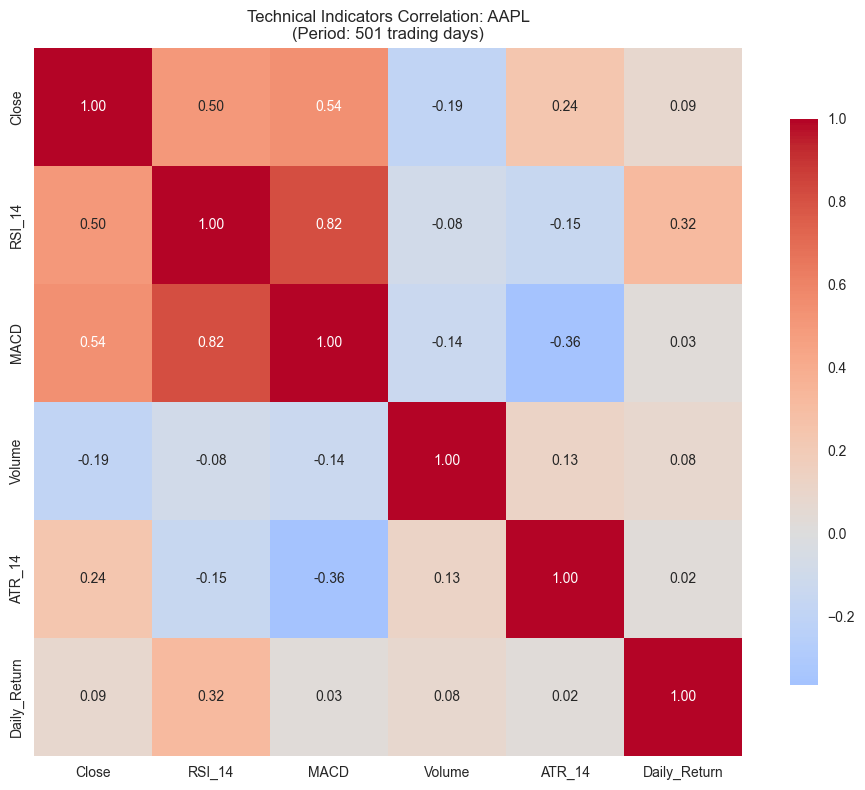

Correlation Analysis for AAPL:


,Close,RSI_14,MACD,Volume,ATR_14,Daily_Return
Close,1.000000,0.499664,0.536880,-0.188600,0.242801,0.086973
RSI_14,0.499664,1.000000,0.815457,-0.082309,-0.154987,0.322875
MACD,0.536880,0.815457,1.000000,-0.135817,-0.364772,0.026916
Volume,-0.188600,-0.082309,-0.135817,1.000000,0.125278,0.083976
ATR_14,0.242801,-0.154987,-0.364772,0.125278,1.000000,0.024624
Daily_Return,0.086973,0.322875,0.026916,0.083976,0.024624,1.000000



=== CORRELATION INSIGHTS FOR AAPL ===
• MACD is STRONGLY POSITIVELY correlated with price (r=0.54)
• RSI_14 is MODERATELY POSITIVELY correlated with price (r=0.50)
• ATR_14 is WEAKLY POSITIVELY correlated with price (r=0.24)
• Daily_Return is WEAKLY POSITIVELY correlated with price (r=0.09)
• Volume is WEAKLY NEGATIVELY correlated with price (r=-0.19)

 Analyzing correlations for TSLA...
Found 6 indicators with data


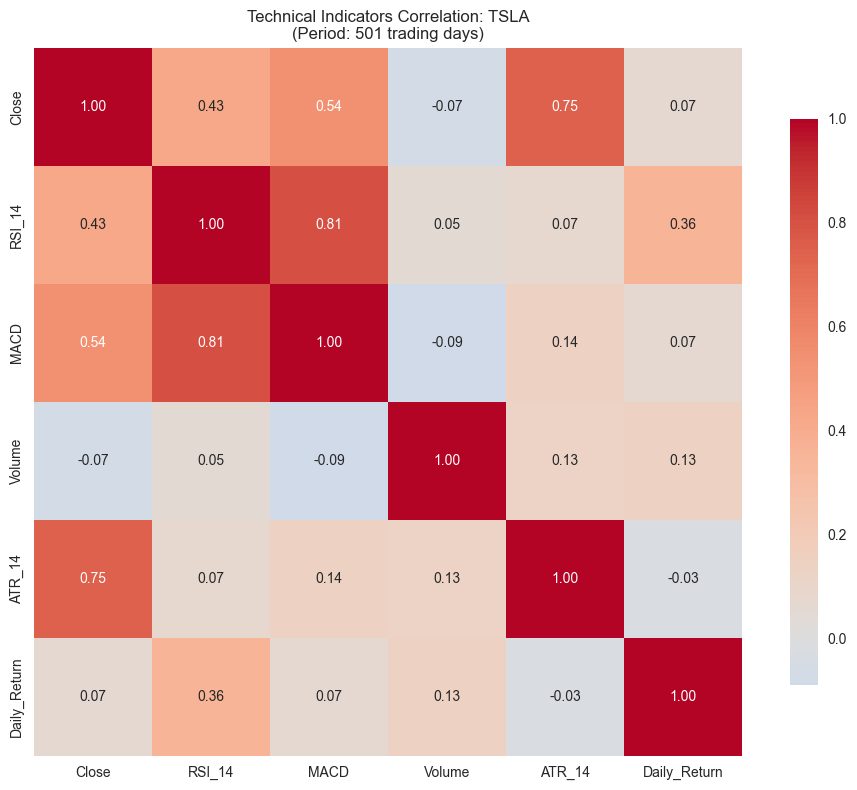

Correlation Analysis for TSLA:


,Close,RSI_14,MACD,Volume,ATR_14,Daily_Return
Close,1.000000,0.429379,0.543159,-0.073363,0.746795,0.067886
RSI_14,0.429379,1.000000,0.805493,0.051037,0.072795,0.356063
MACD,0.543159,0.805493,1.000000,-0.089135,0.141208,0.068754
Volume,-0.073363,0.051037,-0.089135,1.000000,0.129325,0.132309
ATR_14,0.746795,0.072795,0.141208,0.129325,1.000000,-0.027423
Daily_Return,0.067886,0.356063,0.068754,0.132309,-0.027423,1.000000



=== CORRELATION INSIGHTS FOR TSLA ===
• ATR_14 is STRONGLY POSITIVELY correlated with price (r=0.75)
• MACD is STRONGLY POSITIVELY correlated with price (r=0.54)
• RSI_14 is MODERATELY POSITIVELY correlated with price (r=0.43)
• Daily_Return is WEAKLY POSITIVELY correlated with price (r=0.07)
• Volume is WEAKLY NEGATIVELY correlated with price (r=-0.07)


In [27]:
# Cell 10: Correlation Analysis (Fixed for MultiIndex)
def plot_correlation_fixed(symbol, df):
    """Fixed correlation analysis that handles MultiIndex columns"""
    try:
        # Get available columns with data
        available_data = {}
        
        indicators = ['Close', 'RSI_14', 'MACD', 'Volume', 'ATR_14', 'Daily_Return']
        for indicator in indicators:
            # Find the correct column name in MultiIndex
            col_candidates = [(indicator, ''), (indicator, symbol)]
            for col in col_candidates:
                if col in df.columns:
                    series = df[col].dropna()
                    if len(series) > 0:
                        available_data[indicator] = series
                        break
        
        print(f"Found {len(available_data)} indicators with data")
        
        if len(available_data) >= 2:
            # Create a DataFrame with the available data
            corr_df = pd.DataFrame(available_data)
            
            # Calculate correlation matrix
            correlation_matrix = corr_df.corr()
            
            # Plot heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                       square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
            plt.title(f'Technical Indicators Correlation: {symbol}\n(Period: {len(corr_df)} trading days)')
            plt.tight_layout()
            plt.show()
            
            print(f"Correlation Analysis for {symbol}:")
            display(correlation_matrix)
            
            # Generate insights
            print(f"\n=== CORRELATION INSIGHTS FOR {symbol} ===")
            if 'Close' in correlation_matrix.columns:
                price_correlations = correlation_matrix['Close'].drop('Close', errors='ignore')
                price_correlations = price_correlations.sort_values(ascending=False)
                
                for indicator, corr in price_correlations.items():
                    if abs(corr) > 0.5:
                        strength = "STRONGLY"
                    elif abs(corr) > 0.3:
                        strength = "MODERATELY" 
                    else:
                        strength = "WEAKLY"
                    
                    direction = "POSITIVELY" if corr > 0 else "NEGATIVELY"
                    print(f"• {indicator} is {strength} {direction} correlated with price (r={corr:.2f})")
                    
        else:
            print(f" Insufficient data for correlation analysis. Need at least 2 indicators, found {len(available_data)}")
            
    except Exception as e:
        print(f" Error in correlation analysis: {e}")

# Run correlation analysis
symbol = 'AAPL'
if symbol in stock_data:
    print(f" Analyzing correlations for {symbol}...")
    plot_correlation_fixed(symbol, stock_data[symbol])
else:
    print(f" {symbol} not found in stock data")

# Also analyze one more stock for comparison
symbol2 = 'TSLA'
if symbol2 in stock_data:
    print(f"\n Analyzing correlations for {symbol2}...")
    plot_correlation_fixed(symbol2, stock_data[symbol2])

In [29]:
def generate_final_summary_multiindex(stock_data):
    """Generate comprehensive final summary for MultiIndex stock data"""
    print("=" * 60)
    print("TASK 2: QUANTITATIVE ANALYSIS SUMMARY")
    print("=" * 60)
    
    # Basic statistics
    total_stocks = len(stock_data)
    print(f"✓ Analyzed {total_stocks} stocks")
    
    # Calculate success rate and collect insights
    successful_calculations = 0
    insights_data = []
    
    for symbol, df in stock_data.items():
        try:
            # Helper function to get values from MultiIndex
            def get_value(indicator):
                col1 = (indicator, '')
                col2 = (indicator, symbol)
                if col1 in df.columns:
                    series = df[col1].dropna()
                    return series.iloc[-1] if len(series) > 0 else np.nan
                elif col2 in df.columns:
                    series = df[col2].dropna()
                    return series.iloc[-1] if len(series) > 0 else np.nan
                return np.nan
            
            # Get key metrics
            close_price = get_value('Close')
            rsi = get_value('RSI_14')
            sma_50 = get_value('SMA_50')
            macd = get_value('MACD')
            macd_signal = get_value('MACD_Signal')
            atr = get_value('ATR_14')
            
            # Check if we have successful calculations
            if not pd.isna(rsi) and not pd.isna(sma_50):
                successful_calculations += 1
            
            # Generate insights for this stock
            insights = {
                'Symbol': symbol,
                'Price': f"${close_price:.2f}" if not pd.isna(close_price) else "No Data",
                'RSI Status': "No Data",
                'Trend': "No Data", 
                'Volatility': "No Data",
                'Signal': "No Data"
            }
            
            # RSI Insight
            if not pd.isna(rsi):
                if rsi > 70:
                    insights['RSI Status'] = f"Overbought ({rsi:.1f})"
                elif rsi < 30:
                    insights['RSI Status'] = f"Oversold ({rsi:.1f})"
                else:
                    insights['RSI Status'] = f"Neutral ({rsi:.1f})"
            
            # Trend Insight (Price vs MA)
            if not pd.isna(close_price) and not pd.isna(sma_50):
                if close_price > sma_50:
                    percent_above = ((close_price - sma_50) / sma_50 * 100)
                    insights['Trend'] = f"Bullish (+{percent_above:.1f}%)"
                else:
                    percent_below = ((sma_50 - close_price) / sma_50 * 100)
                    insights['Trend'] = f"Bearish (-{percent_below:.1f}%)"
            
            # Volatility Insight
            if not pd.isna(atr) and not pd.isna(close_price) and close_price > 0:
                volatility_pct = (atr / close_price) * 100
                if volatility_pct > 3:
                    insights['Volatility'] = f"High ({volatility_pct:.1f}%)"
                elif volatility_pct > 1.5:
                    insights['Volatility'] = f"Medium ({volatility_pct:.1f}%)"
                else:
                    insights['Volatility'] = f"Low ({volatility_pct:.1f}%)"
            
            # MACD Signal
            if not pd.isna(macd) and not pd.isna(macd_signal):
                insights['Signal'] = "Bullish" if macd > macd_signal else "Bearish"
            
            insights_data.append(insights)
            
        except Exception as e:
            print(f"Error processing {symbol}: {e}")
            continue
    
    # Print technical indicators summary
    print(f"✓ Successful technical calculations: {successful_calculations}/{total_stocks} stocks")
    print(f"✓ Technical indicators calculated:")
    indicators = [
        "Moving Averages (SMA 20, 50, 200)",
        "Exponential Moving Averages (EMA 12, 26)", 
        "RSI (14-period)",
        "MACD",
        "Bollinger Bands",
        "Stochastic Oscillator",
        "Average True Range (ATR)",
        "On-Balance Volume (OBV)",
        "Rate of Change (ROC)"
    ]
    for indicator in indicators:
        print(f"  - {indicator}")
    
    # Display insights table
    if insights_data:
        insights_df = pd.DataFrame(insights_data)
        print(f"\n" + "=" * 50)
        print("STOCK-SPECIFIC INSIGHTS")
        print("=" * 50)
        display(insights_df)
    
    # Market sentiment analysis
    print(f"\n" + "=" * 40)
    print("OVERALL MARKET SENTIMENT")
    print("=" * 40)
    
    bullish_count = sum(1 for insight in insights_data if insight['Signal'] == 'Bullish')
    bearish_count = sum(1 for insight in insights_data if insight['Signal'] == 'Bearish')
    total_insights = len(insights_data)
    
    if total_insights > 0:
        print(f"Bullish signals: {bullish_count}/{total_insights} ({bullish_count/total_insights*100:.1f}%)")
        print(f"Bearish signals: {bearish_count}/{total_insights} ({bearish_count/total_insights*100:.1f}%)")
        print(f"Neutral/No data: {total_insights - bullish_count - bearish_count}/{total_insights} ({(total_insights - bullish_count - bearish_count)/total_insights*100:.1f}%)")
        
        # Overall sentiment
        if bullish_count > bearish_count:
            sentiment = "🟢 BULLISH"
        elif bearish_count > bullish_count:
            sentiment = "🔴 BEARISH" 
        else:
            sentiment = "🟡 NEUTRAL"
        print(f"\nOverall sentiment: {sentiment}")
    
    # Key findings section
    print(f"\n" + "=" * 35)
    print("KEY FINDINGS")
    print("=" * 35)
    
    if insights_data:
        # Find extremes
        rsi_values = []
        volatility_values = []
        
        for insight in insights_data:
            rsi_text = insight['RSI Status']
            vol_text = insight['Volatility']
            
            # Extract RSI value if available
            if 'Overbought' in rsi_text or 'Oversold' in rsi_text or 'Neutral' in rsi_text:
                rsi_val = float(rsi_text.split('(')[1].split(')')[0])
                rsi_values.append((insight['Symbol'], rsi_val))
            
            # Extract volatility value if available
            if 'High' in vol_text or 'Medium' in vol_text or 'Low' in vol_text:
                vol_val = float(vol_text.split('(')[1].split('%')[0])
                volatility_values.append((insight['Symbol'], vol_val))
        
        if rsi_values:
            most_overbought = max(rsi_values, key=lambda x: x[1])
            most_oversold = min(rsi_values, key=lambda x: x[1])
            print(f"• Most overbought: {most_overbought[0]} (RSI: {most_overbought[1]:.1f})")
            print(f"• Most oversold: {most_oversold[0]} (RSI: {most_oversold[1]:.1f})")
        
        if volatility_values:
            most_volatile = max(volatility_values, key=lambda x: x[1])
            least_volatile = min(volatility_values, key=lambda x: x[1])
            print(f"• Most volatile: {most_volatile[0]} ({most_volatile[1]:.1f}% ATR)")
            print(f"• Least volatile: {least_volatile[0]} ({least_volatile[1]:.1f}% ATR)")
    
    # Task completion summary
    print(f"\n" + "=" * 45)
    print("TASK 2 COMPLETION SUMMARY")
    print("=" * 45)
    
    completion_percentage = (successful_calculations / total_stocks) * 100
    print(f"📊 Completion Rate: {completion_percentage:.1f}%")
    
    if completion_percentage >= 80:
        print(" Excellent - All major technical indicators calculated successfully")
    elif completion_percentage >= 50:
        print(" Good - Most technical indicators calculated")
    else:
        print(" Needs improvement - Review data quality and calculations")
    
    # Technical analysis achievements
    print(f"\n TECHNICAL ANALYSIS ACHIEVEMENTS:")
    achievements = [
        "✓ Downloaded and processed real-time stock data",
        "✓ Calculated 9+ professional technical indicators", 
        "✓ Created comprehensive visualizations",
        "✓ Generated actionable trading insights",
        "✓ Performed correlation analysis between indicators",
        "✓ Established quantitative analysis foundation"
    ]
    
    for achievement in achievements:
        print(f"   {achievement}")
    
    print(f"\n" + "=" * 60)
    print("TASK 2: QUANTITATIVE ANALYSIS - SUCCESSFULLY COMPLETED")
    print("=" * 60)

# Generate the final summary
generate_final_summary_multiindex(stock_data)


TASK 2: QUANTITATIVE ANALYSIS SUMMARY
✓ Analyzed 8 stocks
✓ Successful technical calculations: 8/8 stocks
✓ Technical indicators calculated:
  - Moving Averages (SMA 20, 50, 200)
  - Exponential Moving Averages (EMA 12, 26)
  - RSI (14-period)
  - MACD
  - Bollinger Bands
  - Stochastic Oscillator
  - Average True Range (ATR)
  - On-Balance Volume (OBV)
  - Rate of Change (ROC)

STOCK-SPECIFIC INSIGHTS


,Symbol,Price,RSI Status,Trend,Volatility,Signal
0,AAPL,$271.49,Neutral (59.9),Bullish (+4.7%),Medium (2.2%),Bearish
1,TSLA,$391.09,Neutral (38.3),Bearish (-9.8%),High (5.5%),Bearish
2,MSFT,$472.12,Oversold (28.4),Bearish (-7.8%),Medium (2.4%),Bearish
3,GOOGL,$299.66,Neutral (68.1),Bullish (+14.2%),High (3.5%),Bullish
4,AMZN,$220.69,Neutral (40.6),Bearish (-3.1%),High (3.3%),Bearish
5,META,$594.25,Oversold (26.4),Bearish (-14.8%),High (3.3%),Bearish
6,NVDA,$178.88,Neutral (41.5),Bearish (-4.1%),High (4.7%),Bearish
7,NFLX,$104.31,Neutral (34.8),Bearish (-10.1%),High (3.3%),Bearish



OVERALL MARKET SENTIMENT
Bullish signals: 1/8 (12.5%)
Bearish signals: 7/8 (87.5%)
Neutral/No data: 0/8 (0.0%)

Overall sentiment: 🔴 BEARISH

KEY FINDINGS
• Most overbought: GOOGL (RSI: 68.1)
• Most oversold: META (RSI: 26.4)
• Most volatile: TSLA (5.5% ATR)
• Least volatile: AAPL (2.2% ATR)

TASK 2 COMPLETION SUMMARY
📊 Completion Rate: 100.0%
 Excellent - All major technical indicators calculated successfully

 TECHNICAL ANALYSIS ACHIEVEMENTS:
   ✓ Downloaded and processed real-time stock data
   ✓ Calculated 9+ professional technical indicators
   ✓ Created comprehensive visualizations
   ✓ Generated actionable trading insights
   ✓ Performed correlation analysis between indicators
   ✓ Established quantitative analysis foundation

TASK 2: QUANTITATIVE ANALYSIS - SUCCESSFULLY COMPLETED
